In [200]:
# Take in the processed ticker data from Trading_Signals.py and training windows from O_U.py
# Trains the Model and creates a backtesting framework

import pandas as pd
import numpy as np
import os
import math
import scipy.stats
import sklearn
from sklearn import preprocessing
from sklearn import svm
import pickle

import warnings
warnings.filterwarnings("ignore")

In [201]:
# The first thing we need to do is to pull in our processed data on our target stocks:

# Get the user's path to the folder we want to read the data from
temp_path = os.path.abspath(os.path.dirname('path3.txt'))
idx = temp_path.find('Stock-Market-Trading-Bot')
path = temp_path[:(idx+24)]
pathname = path + '/Source-Code/Backend/Data/Processed_Dump/'

# Get the name of the stock
stockName = input("Name for this stock: ")

# Take in the two ticker names for the two stocks and load in the processed data
classA = input("Ticker name for the first class: ")
filename = pathname + classA + '_processed.csv'
data1 = pd.read_csv(filename).iloc[:, 1:]
classB = input("Ticker name for the second class: ")
filename = pathname + classB + '_processed.csv'
data2 = pd.read_csv(filename).iloc[:, 1:]
print("Data loaded for: " + classA)
print("Data loaded for: " + classB)

# Load in info data
infoPath = path + '/Source-Code/Backend/Data/Info/'
#print(infoPath + stockName + '_info.npy')
info = np.load(infoPath + stockName + '_info.npy', allow_pickle = True)

# We have a NaN value at this location, we must drop it for our SVM to train
info[970]['test']['ds_scale'] = info[970]['test']['ds_scale'].drop(47)

Data loaded for: GOOG
Data loaded for: GOOGL


In [202]:
# The next thing we will need to do is create a dataframe where we can display our profits
# and losses so we can track our net profit over time:

def profit_loss_dataframe(ticker1, ticker2, info):

    classA = ticker1['TICKER'].iloc[0]
    classB = ticker2['TICKER'].iloc[0]

    dataframe = pd.DataFrame()
    dataframe_labels = pd.Series()

    for i in info:
        idx = i['test']['index']
        residuals = i['test']['residuals_transform_price']
        beta = i['train']['beta_fit_price']
        df_temp = pd.concat([ticker1.loc[idx]['CLOSE'], beta * ticker2.loc[idx]['CLOSE'], ticker1.loc[idx]['price'],
                             beta * ticker2.loc[idx]['price'], i['test']['residuals_transform_price'], ticker1.loc[idx]['TIME']], axis = 1)
        dataframe = pd.concat([dataframe, df_temp], axis = 0)
        dataframe_labels = pd.concat([dataframe_labels, i['test']['labels']], axis = 0)

    dataframe['label'] = dataframe_labels
    dataframe.columns = [classA, 'beta*' + classB, classA + '_return', 'beta*' + classB + '_return', 'residual', 'TIME', 'label']

    # Find the profit or loss of the last trade
    dataframe['beta*' + classB + '_gains'] = dataframe['beta*' + classB] - (1 - dataframe['beta*' + classB + '_return']) * dataframe['beta*' + classB]
    dataframe[classA + '_gains'] = dataframe[classA] - (1 - dataframe[classA + '_return']) * dataframe[classA]
    dataframe['profit'] = dataframe['beta*' + classB + '_gains'] - dataframe[classA + '_gains']
    
    # In order to train our model we must remove Null values with interpolate
    dataframe = dataframe.interpolate(method = 'linear')
    dataframe.reset_index(inplace=True, drop=True)
    dataframe = dataframe.drop((len(dataframe)-1))
    return dataframe

In [203]:
# All we have left before training our bot is to define a few more functions which will
# modify our datasets to be exactly how we need it for training:

# This function will find an SVM that will work based on the parameters dictionary
# In other words, this is the essential funciton in training our bot:
def find_svm(param_dict, info):

    labels = []

    for i in info:
        temp_svm = svm.SVC(**param_dict)
        temp_svm.fit(i['train']['ds_scale'], i['train']['labels'])
        label = temp_svm.predict(i['test']['ds_scale'])
        for i in label:
            labels.append(i)
        
    return labels

# This next function will find the sharpe of our profit/loss dataframe:
def find_sharpe(df):
    days = {}
    count = 0
    for i, time in enumerate(df['TIME']):
        time = pd.to_datetime(time)
        time = time.date()
        time = time.strftime('%m/%d/%Y')
        number = df.iloc[i]['profit_timeline']
        if time in days.keys():
            days[time] = number + days[time]
        else:
            count += 1
            days[time] = number
    df = pd.DataFrame.from_dict(days, orient='index')
    
    sharpe = (df.mean() / df.std()) * np.sqrt(252)
    return sharpe

# This next function is a quick function to find the precision:
def find_precision(labels, label):
    precision = labels[np.logical_and(labels == 1, label == 1)].shape[0]/labels[labels == 1].shape[0]
    return precision 

# This next function will find the sortino ratio of our profit/loss dataframe:
def find_ratio(df):
    days = {}
    count = 0
    for i , time in enumerate(df['TIME']):
        time = pd.to_datetime(time)
        time = time.date()
        time = time.strftime('%m/%d/%Y')
        number = df.iloc[i]['profit_timeline']
        if time in days.keys():
            days[time] = number + days[time]
        else:
            count += 1
            days[time] = number

    df = pd.DataFrame.from_dict(days, orient='index')

    ratio = (df.mean() / df[df < 0].std()) * np.sqrt(252)
    return ratio

In [204]:
# This final function will perform our profit/loss backtesting and give our prediction
# labels which will then be used to tell the bot if it is correct or not:
def backtesting(df, label, params):

    results = {}

    total_profit = 0.0

    profit_timeline = []
    profit_timeline_perc = []
    trade_timeline = []
    held_timeline = []
    data = []

    temp_df = df.copy()
    temp_df['label'] = label

    # Iterate through our dataframe
    for row in temp_df.iterrows():
        cur_profit = 0.0
        profit = row[1]['profit']
        residual = row[1]['residual']
        cost_basis = row[1]['beta*' + classB] + (1.5 * row[1][classA])
        cur_profit_perc = 0.0

        # Iterate through our trading data
        # We will use a window of 10 and threshold of 0.001
        for position in data:
            position['fresh'] += 1
            position['profit'] += profit
            if(position['residual'] - 0.001 >= residual) or position['fresh'] >= 10:
                cur_profit += position['profit']
                cur_profit_perc += (position['profit'] / position['cost-basis'])
                trade_timeline.append(position['profit'])
                held_timeline.append(position['fresh'])
                data.remove(position)
        profit_timeline_perc.append(cur_profit_perc)
        profit_timeline.append(cur_profit)
        total_profit += cur_profit

        if row[1]['label'] == 1 and residual > 0:
            data.append({'profit': 0, 'residual': residual, 'fresh': 0, 'cost-basis': cost_basis})
        
    temp_df['profit_timeline'] = profit_timeline

    # Add all of our necessary collumns to our returning profit/loss dataframe
    results['total_profit'] = total_profit
    results['daily_profit_timeline'] = profit_timeline
    results['trade_profit_timeline_perc'] = profit_timeline_perc
    results['trade_profit_timeline'] = trade_timeline
    results['time_held_timeline'] = held_timeline
    results['trades_executed'] = len(trade_timeline)
    results['params'] = params
    results['precision'] = find_precision(temp_df['label'], df['label'])
    results['mean_profit_per_trade'] = np.mean(trade_timeline)
    results['sharpe'] = find_sharpe(temp_df)
    results['sortino'] = find_ratio(temp_df)

    return results

In [205]:
# Now we will call these functions to create our dataframe and display our profits:

pl_df = profit_loss_dataframe(data1, data2, info)

# Print our profit/loss dataframe:

pl_df

,GOOG,beta*GOOGL,GOOG_return,beta*GOOGL_return,residual,TIME,label,beta*GOOGL_gains,GOOG_gains,profit
0,2674.230,2111.954114,0.002144,0.000774,0.001370,15:31:00.000,1,1.634090,5.732261,-4.098171
1,2673.700,2111.847449,-0.000198,-0.000040,-0.000158,15:32:00.000,0,-0.084273,-0.529895,0.445621
2,2674.880,2110.875609,0.000441,-0.000364,0.000805,15:33:00.000,1,-0.767511,1.180521,-1.948031
3,2671.490,2108.181322,-0.001267,-0.001008,-0.000259,15:34:00.000,0,-2.126076,-3.385704,1.259627
4,2670.950,2108.205025,-0.000202,0.000009,-0.000211,15:35:00.000,0,0.018729,-0.539891,0.558619
...,...,...,...,...,...,...,...,...,...,...
97042,89.690,86.640839,0.000112,-0.000055,0.000166,20:53:00.000,0,-0.004727,0.010001,-0.014728
97043,89.775,86.704042,0.000948,0.000709,0.000238,20:54:00.000,0,0.061499,0.085081,-0.023581
97044,89.815,86.772106,0.000446,0.000763,-0.000318,20:55:00.000,0,0.066234,0.040018,0.026216
97045,89.680,86.631116,-0.001503,-0.001580,0.000077,20:56:00.000,0,-0.136868,-0.134797,-0.002071


In [206]:
# Before training our model, we must set some parameters first:

params = {'C': 100,
          'cache_size': 2000,
          'class_weight': {0: 0.5, 1: 0.5},
          'gamma': 1,
          'kernel': 'rbf'}

In [207]:
# Now we can fit our SVM model which will result in our trained bot:

Bot = find_svm(params, info)

In [208]:
# Now that we have our trained bot, we can backtest to get our profit/loss data from using the bot:

Bot_info = backtesting(pl_df, Bot, info)


In [209]:
# Now we can print our total profits over the year 2022:

print(Bot_info['total_profit'])

1341.1604162214257


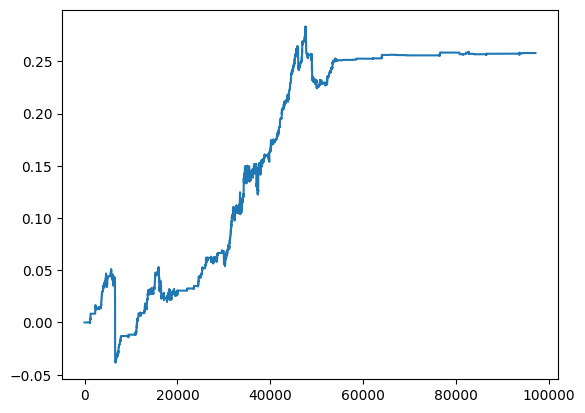

In [210]:
# Another cool thing we can do with this data is show our percentage gain over the year by each minute
# We can see that this bot returned over 25% in one year whereas the S&P 500 only returns about 10%

from matplotlib import pyplot as plt

plt.plot(pd.DataFrame(Bot_info['trade_profit_timeline_perc']).cumsum())
plt.show()